# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

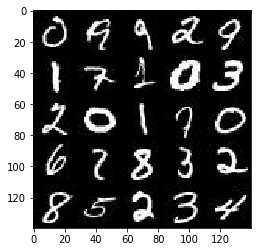

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

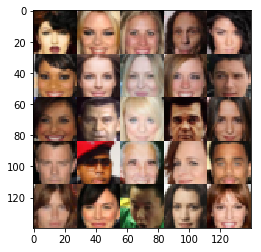

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_r = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, inputs_z, learn_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)

        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        gen_updates = [op for op in update_ops if op.name.startswith('generator')]

    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # TODO: Build Model
    input_real, input_z, learn_r = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    n_samples = 25
    steps = 0
    print_every=10
    show_images_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_r: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_r: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_r: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    

                if steps % show_images_every == 0:
                    show_generator_output(sess, n_samples, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.2621... Generator Loss: 0.0242
Epoch 1/2... Discriminator Loss: 2.9267... Generator Loss: 0.3061
Epoch 1/2... Discriminator Loss: 3.2134... Generator Loss: 0.0769
Epoch 1/2... Discriminator Loss: 2.9410... Generator Loss: 0.1478
Epoch 1/2... Discriminator Loss: 2.4902... Generator Loss: 0.1394
Epoch 1/2... Discriminator Loss: 2.3139... Generator Loss: 0.1768
Epoch 1/2... Discriminator Loss: 2.1516... Generator Loss: 0.1903
Epoch 1/2... Discriminator Loss: 2.0385... Generator Loss: 0.3057
Epoch 1/2... Discriminator Loss: 1.9206... Generator Loss: 0.2834
Epoch 1/2... Discriminator Loss: 1.7134... Generator Loss: 0.4132


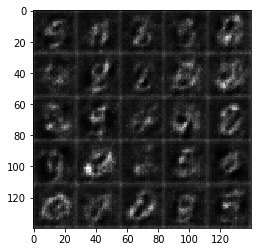

Epoch 1/2... Discriminator Loss: 1.8811... Generator Loss: 0.2961
Epoch 1/2... Discriminator Loss: 1.5926... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.5929... Generator Loss: 0.8700
Epoch 1/2... Discriminator Loss: 1.4969... Generator Loss: 0.5021
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 1.3110
Epoch 1/2... Discriminator Loss: 1.6038... Generator Loss: 1.1023
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.4313
Epoch 1/2... Discriminator Loss: 1.7604... Generator Loss: 0.3014
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.8601
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 1.6117


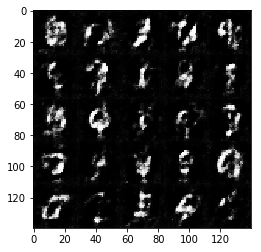

Epoch 1/2... Discriminator Loss: 1.6698... Generator Loss: 0.3418
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 1.1446
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 2.2396
Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 0.8717
Epoch 1/2... Discriminator Loss: 1.6195... Generator Loss: 0.4295
Epoch 1/2... Discriminator Loss: 1.4921... Generator Loss: 0.5643
Epoch 1/2... Discriminator Loss: 1.5388... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 1.8714... Generator Loss: 0.2705
Epoch 1/2... Discriminator Loss: 1.5007... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 1.0556


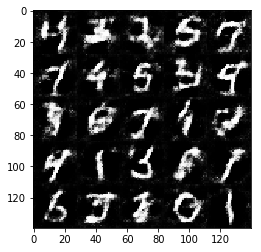

Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 1.7492... Generator Loss: 0.3095
Epoch 1/2... Discriminator Loss: 1.4820... Generator Loss: 1.6587
Epoch 1/2... Discriminator Loss: 1.9180... Generator Loss: 0.2579
Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 0.5561
Epoch 1/2... Discriminator Loss: 1.5065... Generator Loss: 0.4381
Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.5125
Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.7534... Generator Loss: 0.3217
Epoch 1/2... Discriminator Loss: 2.0340... Generator Loss: 0.2371


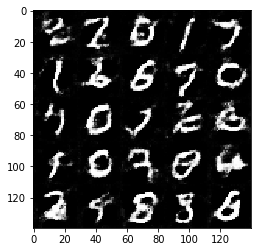

Epoch 1/2... Discriminator Loss: 1.6157... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 1.0174
Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 0.3762
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 1.6180... Generator Loss: 0.3767
Epoch 2/2... Discriminator Loss: 1.5478... Generator Loss: 0.3843
Epoch 2/2... Discriminator Loss: 1.5119... Generator Loss: 1.6240
Epoch 2/2... Discriminator Loss: 1.3419... Generator Loss: 1.1507
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.5273


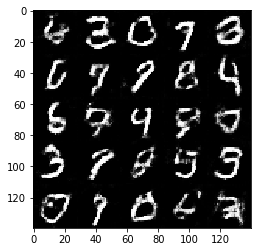

Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 1.2238... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 1.8262... Generator Loss: 0.2999
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.6637
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.8826
Epoch 2/2... Discriminator Loss: 1.3363... Generator Loss: 1.1094
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 0.7896
Epoch 2/2... Discriminator Loss: 1.4832... Generator Loss: 0.4562
Epoch 2/2... Discriminator Loss: 1.7106... Generator Loss: 0.3347
Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 0.8582


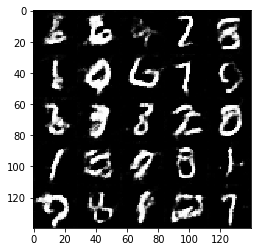

Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 1.2394
Epoch 2/2... Discriminator Loss: 1.5600... Generator Loss: 0.4111
Epoch 2/2... Discriminator Loss: 2.3313... Generator Loss: 0.1666
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.6411
Epoch 2/2... Discriminator Loss: 1.5450... Generator Loss: 0.4040
Epoch 2/2... Discriminator Loss: 1.3572... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.4194... Generator Loss: 0.7200
Epoch 2/2... Discriminator Loss: 1.4835... Generator Loss: 0.4780
Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 0.4638
Epoch 2/2... Discriminator Loss: 1.9644... Generator Loss: 0.2415


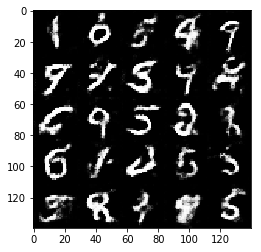

Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.8246
Epoch 2/2... Discriminator Loss: 2.1769... Generator Loss: 0.2040
Epoch 2/2... Discriminator Loss: 1.2326... Generator Loss: 0.6284
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 2.0273... Generator Loss: 0.2340
Epoch 2/2... Discriminator Loss: 1.4299... Generator Loss: 0.4968
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.7663
Epoch 2/2... Discriminator Loss: 1.6309... Generator Loss: 0.3965
Epoch 2/2... Discriminator Loss: 1.5735... Generator Loss: 0.3971


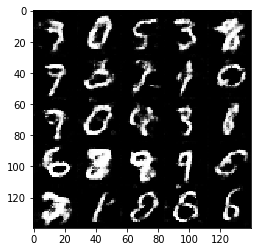

Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.6144
Epoch 2/2... Discriminator Loss: 1.7484... Generator Loss: 0.3004
Epoch 2/2... Discriminator Loss: 1.8892... Generator Loss: 0.2773
Epoch 2/2... Discriminator Loss: 1.2175... Generator Loss: 0.8446
Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 0.4751
Epoch 2/2... Discriminator Loss: 1.2827... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 1.8104... Generator Loss: 0.2946
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.6052
Epoch 2/2... Discriminator Loss: 1.6627... Generator Loss: 0.3531


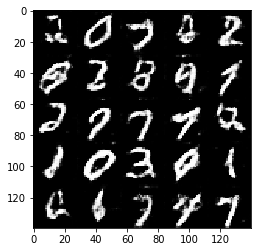

Epoch 2/2... Discriminator Loss: 1.7270... Generator Loss: 0.3290
Epoch 2/2... Discriminator Loss: 1.4543... Generator Loss: 0.4711
Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 0.9074


In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.7362... Generator Loss: 0.0137
Epoch 1/1... Discriminator Loss: 4.6621... Generator Loss: 0.0177
Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 2.1236... Generator Loss: 0.3059
Epoch 1/1... Discriminator Loss: 2.2313... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 2.2695... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 2.2726... Generator Loss: 0.3388
Epoch 1/1... Discriminator Loss: 1.8672... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 1.7496... Generator Loss: 0.3935
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.4691


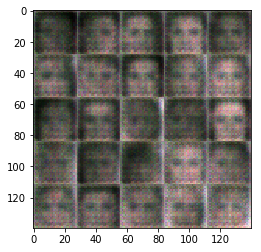

Epoch 1/1... Discriminator Loss: 1.6677... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 0.3831
Epoch 1/1... Discriminator Loss: 2.1361... Generator Loss: 0.2621
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7191


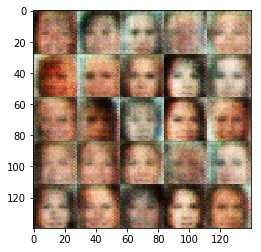

Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.7604... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6162


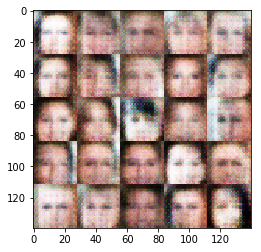

Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.6332... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7749


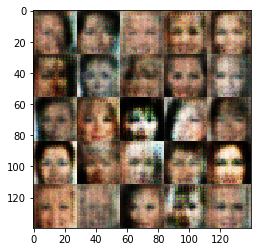

Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.5921... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.6521


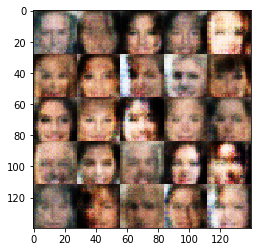

Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8189


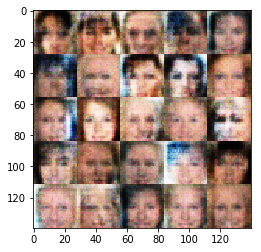

Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7855


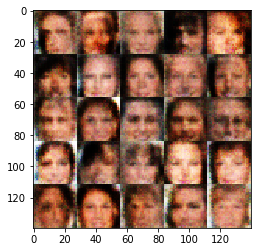

Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.6924


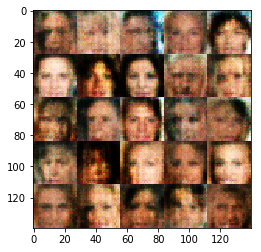

Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6175


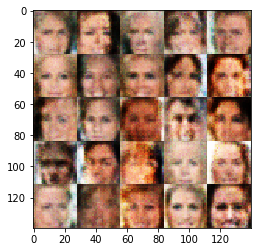

Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7518


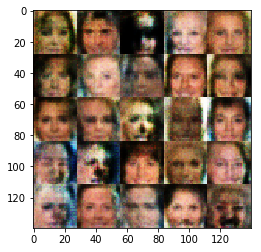

Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.5295


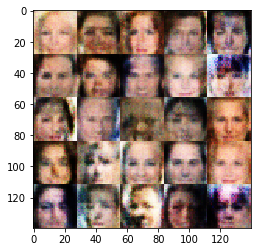

Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.5068
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6321


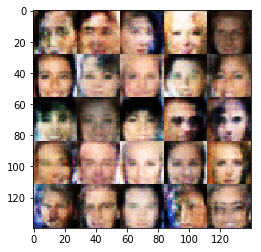

Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.6188... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8165


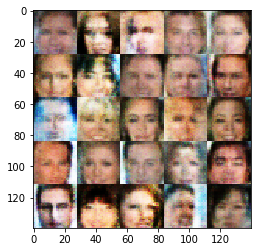

Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.6608... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7027


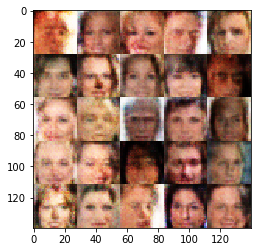

Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 1.0248


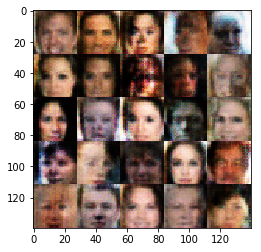

Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.3862


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.